# Problem Description
Teamfight Tactics (abbreviated "TFT") is a popular strategy game developed and published by Riot Games. Riot has made records of TFT matches available via their API, and thus analysis of statistics and metrics from this data has become an established aspect of its competitive circuit. Due to the game heavily leveraging resource management skills, it is valuable to understand the relative worth of different types of resources available in a given game. In this project I will be seeking to analyze some of the resources, items and gold, in TFT as they appear in end-of-game board data. From these I will be formulating a regression model for how well any given final board should be expected to perform.

## Gameplay Summary

In TFT, players are given a random "shop", from which they buy units to put on their board. After they have prepared their board, it will be matched against another player's board for a fight. The loser of the fight loses some of their "player hp", and is eliminated if that HP total drops below zero. Players are also periodically granted other mechanisms to enhance their boards, such as items to equip on their units, or "augments", which can themselves grant more money, items, or other powerful effects.

In [528]:
from json import loads
from pathlib import Path
import itertools

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

from constants import *

# Data Sourcing

## Match Data
Riot Games. *TFT Challenger Match Records 9/25/25 - 10/1/25* [Data set] Retrieved 9/28/25, from https://developer.riotgames.com/

A csv of this data is available at https://storage.googleapis.com/ml_school_projects/match_data.csv

The data was gathered from all server realms for which data is available. It consists of ranked matches played by "challenger" (the highest rank tier) players between 9/25/25 and 10/1/25, on TFT patch 15.5 (corresponds to League of Legends client patch 15.19). My restriction to ranked challenger matches is partially due to the rate limiting constraints Riot has on its API endpoints; it is not feasible to scrape all matches played with my current API rate limits. But it is also because those playing in these matches are incentivized to play to the best of their ability. I would not expect these players to frequently do counter-intuitive things such as say, forfeiting a game they have a dominating position in. This should mitigate one potential source of variance.

The result of this API scrapping yielded 20677 match records in total. Each match json record consists of the following fields:
<style>
    th, td { text-align: left !important; }
</style>
<table style="width:70%">
    <tr>
        <th>Name</th><th>Type</th><th>Description</th>
    </tr>
    <tr>
        <td>match_id</td><td>string</td>
        <td>
            2-3 character code for the regional server the match was played on, followed by an underscore and then a 10-digit integer that uniquely identifies that match.
        </td>
    </tr>
    <tr>
        <td>endOfGameResult</td><td>string</td>
        <td>
            Manner in which the game concluded. Can be "GameComplete" or "Abort_Unexpected".
        </td>
    </tr>
    <tr>
        <td>gameCreation</td><td>timestamp</td>
        <td>
            Unix timestamp of when game is created on Riot's game servers, in milliseconds.
        </td>
    </tr>
    <tr>
        <td>gameId</td><td>integer</td>
        <td>
            Uniquely identifies the match. Same as identifier in match_id.
        </td>
    </tr>
    <tr>
        <td>game_length</td><td>float</td>
        <td>
            Game duration in seconds.
        </td>
    </tr>
    <tr>
        <td>game_version</td><td>string</td>
        <td>
            Describes version of the game client that the match was played on. 
        </td>
    </tr>
    <tr>
        <td>mapId</td><td>integer</td>
        <td>
            Describes whether this is a League of Legends game or a Teamfight Tactics game. Should = 22 for all TFT games.
        </td>
    </tr>
    <tr>
        <td>participants</td><td>list</td>
        <td>
            Will consist of 8 json elements, each representing the end of game board state for one player in the game.
        </td>
    </tr>
    <tr>
        <td>queue_id</td><td>integer</td>
        <td>
            Identifies the TFT game queue selected (Normal or Ranked). Because we are only looking at Ranked games, will be 1100 for all records in this data set.
        </td>
    </tr>
    <tr>
        <td>queueId</td><td>integer</td>
        <td>
            Same as queue_id - should always be same value. (Docs indicate this field is deprecated)
        </td>
    </tr>
    <tr>
        <td>tft_game_type</td><td>string</td>
        <td>
            Denotes the TFT game mode (Standard, Ao Shin's Ascent, Set Revivals, etc). For our data set, all records have "standard" in this field.
        </td>
    </tr>
    <tr>
        <td>tft_set_core_name</td><td>string</td>
        <td>
            Unique identifier of the TFT "set" the game was played on. TFT sets rotate roughly every 3 months. All of the games in this dataset were played within the same set rotation, and thus will all have the same value in this field.
        </td>
    </tr>
    <tr>
        <td>tft_set_number</td><td>integer</td>
        <td>
            TFT set number. This increments upon every TFT set rotation. Again, all games in this dataset were played on the same TFT set, therefore this field has the same value for all  of the records.
        <td>
    </tr>
</table>

## Game Metadata
Community Dragon. *TFT Game Client Data, Patch 15.6* [Data set] Retrieved 10/10/25, from https://raw.communitydragon.org/

Game records will frequently reference specific game elements by name (units, items, traits). It can thus be necessary to augment our game records with additional information about those game pieces in order to properly interpret it. I obtained my metadata from Community Dragon, a Riot Games community-driven project that seeks to make this game metadata available to content creators. Community Dragon reads their data from game client data files, transforms it into a convenient json format, and publishes it on their site. As I am only concerned with TFT data corresponding to the patch my game records were played on, everything I need is in a single data file, which is included in the raw data for this project (`raw_data/cdragon.json`)

# Data Cleaning
## Initial Data Tranformation


In [529]:
raw_data = pd.read_csv('data/match_data.csv', converters={"info": loads})

unpacked_info = pd.json_normalize(raw_data['info'])

# Each match_id is prefixed with the name of the regional server realm it belongs to.
# We're going to map these match_id prefixes to human-readable region names.
initial_df = pd.concat([raw_data['match_id'], unpacked_info], axis="columns")
initial_df['server_code'] = initial_df['match_id'].apply(lambda x: x.split('_')[0])
initial_df['region'] = initial_df['server_code'].apply(lambda x: SERVER_INFO[x]["name"])

# Each match has 8 players
# We want a data record for each player, so explode that data field.
expanded = initial_df.explode(column='participants', ignore_index=True)
unpacked_player_record = pd.json_normalize(expanded['participants'])
expanded.pop('participants')
transformed = pd.concat([expanded, unpacked_player_record], axis="columns")

# Games are divided into "stages" of 7 rounds, with the first stage being shorter (only 3)
transformed["last_stage"] = np.ceil((transformed["last_round"] + 4)/7.0).astype(int)

# Finally, lets see a summary of our initial data
transformed.describe()

,mapId,gameId,queueId,queue_id,game_length,gameCreation,tft_set_number,level,gold_left,placement,last_round,time_eliminated,players_eliminated,total_damage_to_players,last_stage
count,165416.0,1.654160e+05,165416.0,165416.0,165416.000000,1.654160e+05,165416.0,165416.000000,165416.000000,165416.000000,165416.000000,165416.000000,165416.000000,165416.000000,165416.000000
mean,22.0,3.731974e+09,1100.0,1100.0,2175.885075,1.759002e+12,15.0,8.465233,8.368459,4.495938,31.760845,1865.010108,0.771171,99.199285,5.485799
std,0.0,3.011246e+09,0.0,0.0,149.258310,1.468745e+08,0.0,0.838845,17.718193,2.293064,4.711390,273.797536,1.060508,60.023639,0.713622
min,22.0,1.424435e+07,1100.0,1100.0,0.000000,1.758756e+12,15.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,22.0,1.052165e+09,1100.0,1100.0,2084.893311,1.758876e+12,15.0,8.000000,0.000000,2.000000,28.000000,1660.448700,0.000000,62.000000,5.000000
50%,22.0,3.146732e+09,1100.0,1100.0,2170.217773,1.758991e+12,15.0,9.000000,1.000000,4.000000,31.000000,1874.025574,0.000000,93.000000,5.000000
75%,22.0,7.543754e+09,1100.0,1100.0,2266.809082,1.759128e+12,15.0,9.000000,8.000000,6.000000,35.000000,2065.390869,1.000000,132.000000,6.000000
max,22.0,7.840949e+09,1100.0,1100.0,2749.761230,1.759274e+12,15.0,10.000000,2635.000000,8.000000,47.000000,2741.550049,6.000000,10257.000000,8.000000


In [530]:
# Set metadata is also in a json format
# What will be needed is nested with many other types of data, we'll have to extract it
with Path('data/cdragon.json').open(encoding='utf-8') as f:
    base = loads(f.read())

In [531]:
# json contains unit data for many game modes;
# we have to select out the one relevant to the matches played
unit_data = {}
for item in base['setData']:
    if item['mutator'] == 'TFTSet15':
        unit_data = item['champions']

# We're fundamentally interested in the gold it would cost to obtain the units on any given board
# So, going to grab the cost of units and discard the other metadata
unit_cost_map = {}
for unit in unit_data:
    # Need this condition to exclude units that can't be bought ie summoned units
    # Some non-purchasable units have a cost in data, don't want that mixed in
    if len(unit['traits']) > 0:
        unit_cost_map[unit['apiName'].upper()] = unit['cost']

Now for items. Items belong to 1 of 5 possible categories. These categories are identified in game files with hash code tags. 

In addition to these 5 categories, there are a few items that themselves can generate "temporary" items on their holder (called "TG" items, for the prototypical item that does this, Thief's Gloves). Because these temporary items aren't a permanent resource for a player, we don't want to count them. Therefore, we're going to need to flag the items that behave this way, so that later on we can tally them correctly.

All item detail records are listed together regardless of game mode. However, records don't explicitly state what game modes they are applicable to. So in a few cases we have to check other conditions in addition to the presence of the designated hash code, in order to filter out items intended for other game modes.

In [532]:
tg_items = []
emblems = []
craftables = []
radiants = []
artifacts = []
tac_items = []

for item_record in base['items']:

    if TG_ITEM_HASH in item_record['tags']:
        tg_items.append(item_record['apiName'].upper())
    if (
        EMBLEM_ITEM_HASH in item_record['tags']
        and item_record['apiName'].split('_')[0] == 'TFT15'
    ):
        emblems.append(item_record['apiName'].upper())
    elif (
        RADIANT_ITEM_HASH in item_record['tags']
        and not EMBLEM_ITEM_HASH in item_record['tags']
        and item_record['name'].startswith('Radiant')
    ):
        radiants.append(item_record['apiName'].upper())
    elif ARTIFACT_ITEM_HASH in item_record['tags']:
        artifacts.append(item_record['apiName'].upper())
    elif TAC_ITEM_HASH in item_record['tags']:
        tac_items.append(item_record['apiName'].upper())
    elif CRAFTABLE_ITEM_HASH in item_record['tags'] and item_record['composition']:
        craftables.append(item_record['apiName'].upper())

In [533]:
def calc_board_item_counts(board_record: pd.Series):
    
    counts = {
        'radiant_total': 0,
        'tac_item_total': 0,
        'artifact_total': 0,
        'craftable_total': 0,
        'emblem_total': 0
    }
    for unit in board_record['units']:
    
        clean_names = [x.upper() for x in unit['itemNames']]
    
        # First lets check for TG Items...
        
        my_tg_items = set(clean_names) & set(tg_items)
        
        if my_tg_items:
            
            # Should be only one
            item = my_tg_items.pop()
            
            # Check for the radiant version of TG...
            if item in radiants:
                counts['radiant_total'] += 1
            elif item in craftables:
                counts['craftable_total'] += 1
            else:
                print(item)
                raise Exception
            continue
            
        for item in clean_names:
            if item in craftables:
                counts['craftable_total'] += 1
            elif item in radiants:
                counts['radiant_total'] += 1
            elif item in artifacts:
                counts['artifact_total'] += 1
            elif item in emblems:
                counts['emblem_total'] += 1
            elif item in tac_items:
                counts['tac_item_total'] += 1
    return pd.concat([board_record, pd.Series(counts)])

There are two aspects of each board that contribute to its gold value: units, and player level. 

Each unit can cost between 1 and 5 gold. Collecting 3 copies of a base unit upgrades it to a "2-star" version; 3 copies of the "2-star" version upgrades to a "3-star" version. Therefore the gold cost of a unit with base cost $B$ and star level $s$ is $B*3^{s-1}$

Player levels can range from 1 to 10, but there is not a standard formula for how much each level costs. So we'll have to reference a hard-coded list for that.

In [534]:
def calc_board_gold_value(board_record: pd.Series):
    
    player_level_value = sum(LEVEL_COSTS[:board_record['level']-1])
    total_unit_cost = 0
    
    for unit in board_record['units']:
        
        cost = unit_cost_map.get(unit['character_id'].upper(), 0)
        total_unit_cost += cost * (3 ** (unit['tier']-1)) 
    
    new_fields = pd.Series({
        'player_level_value': player_level_value, 
        'unit_value': total_unit_cost, 
        'total_board_value': player_level_value + total_unit_cost + board_record['gold_left']
    })
    return pd.concat([board_record, new_fields])

In [535]:
transformed = transformed.apply(calc_board_item_counts, axis='columns')
transformed = transformed.apply(calc_board_gold_value, axis='columns')

## Initial Data Filtering

In [536]:
# We are definitely only interested in games on latest 15.19 patch client version, that didn't end in an error state
filtered = transformed[(transformed["endOfGameResult"]=="GameComplete") & (transformed["game_version"].str.contains("15.19.715.1836"))]
filtered = filtered.drop(columns = ["endOfGameResult", "game_version"])

# These fields all have the same value - so they aren't going to be adding any information
filtered = filtered.drop(columns = ["mapId", "queueId", "queue_id", "tft_game_type", "tft_set_number", "tft_set_core_name"])

# These are a "human readable" form of the puuid field. As such they are going to be redundant with it.
filtered = filtered.drop(columns = ["riotIdGameName", "riotIdTagline"])
numeric_features = filtered[[
    "placement", "game_length", "level", "gold_left", "last_round", "last_stage", "players_eliminated", "total_damage_to_players", 
    "radiant_total", "tac_item_total", "artifact_total", "craftable_total", "emblem_total",
    "player_level_value", "unit_value", "total_board_value"
]]
numeric_features.describe()

,placement,game_length,level,gold_left,last_round,last_stage,players_eliminated,total_damage_to_players,radiant_total,tac_item_total,artifact_total,craftable_total,emblem_total,player_level_value,unit_value,total_board_value
count,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000,105968.000000
mean,4.500000,2180.147329,8.473407,8.313246,31.786049,5.488204,0.772969,99.430668,0.186462,0.063934,0.336385,9.949438,0.345699,230.664672,72.798864,311.776782
std,2.291299,130.163835,0.797047,17.644533,4.581820,0.696198,1.061955,65.379551,0.626066,0.253726,0.668340,2.431271,0.770387,101.090160,20.838494,109.303600
min,1.000000,1765.856201,4.000000,0.000000,11.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,24.000000
25%,2.750000,2087.015869,8.000000,0.000000,28.000000,5.000000,0.000000,63.000000,0.000000,0.000000,0.000000,8.000000,0.000000,160.000000,58.000000,225.000000
50%,4.500000,2171.945068,9.000000,1.000000,31.000000,5.000000,0.000000,93.000000,0.000000,0.000000,0.000000,10.000000,0.000000,286.000000,71.000000,335.000000
75%,6.250000,2268.419922,9.000000,8.000000,35.000000,6.000000,1.000000,132.000000,0.000000,0.000000,1.000000,11.000000,1.000000,286.000000,85.000000,369.000000
max,8.000000,2749.761230,10.000000,2635.000000,47.000000,8.000000,6.000000,10257.000000,10.000000,3.000000,7.000000,24.000000,16.000000,488.000000,379.000000,3502.000000


# Exploratory Data Analysis
## Pair Plot Analysis
To keep processing time reasonable & maintain plot readability, I broke my initial feature exploration out into 3 subsets. All will be compared vs placement, my dependent variable.


In [537]:
def pairgrid_heatmap(x, y, **kws):
    if x.dtype == np.int64 and x.nunique() < 20 and x.max() < 20 and x.min() >= 0:
        x_bins = x.nunique()
    else:
        x_bins = 10 # normal default value
    
    if y.dtype == np.int64 and y.nunique() < 20 and y.max() < 20 and y.min() >= 0:
        y_bins = y.nunique()
    else:
        y_bins = 10 # normal default value
    
    kws["bins"] = [x_bins, y_bins]

    cmap = sns.light_palette(kws.pop("color"), as_cmap=True, n_colors=20)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)
    
def wrap_hist(x, **kws):
    if x.dtype == np.int64 and x.nunique() < 20 and x.max() < 20 and x.min() >= 0:
        kws['bins'] = x.nunique()
    plt.hist(x, **kws)

def get_min_max_mean_std(df, column_name):
    return df[column_name].min(), df[column_name].max(), df[column_name].mean(), df[column_name].std()


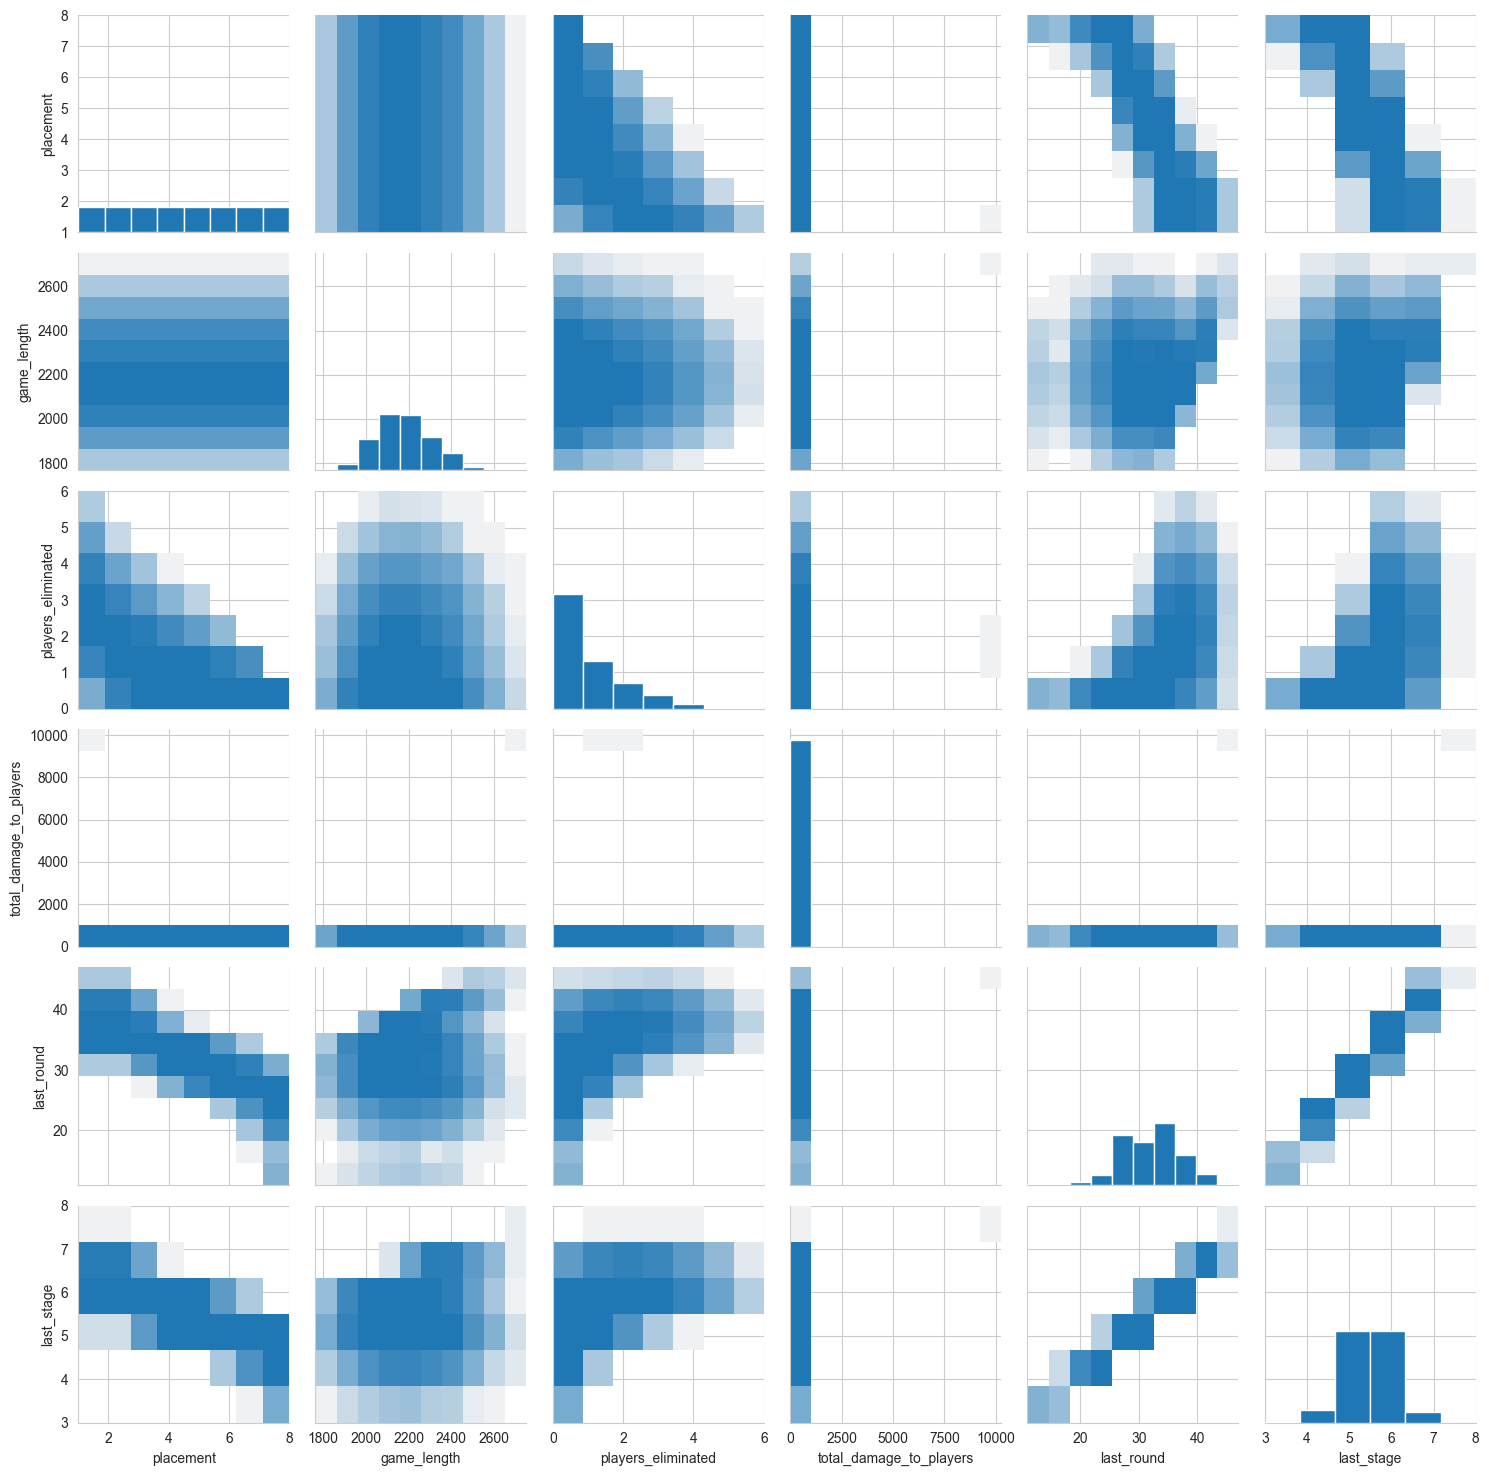

In [538]:
# Top-level fields - ones that I didn't calculate/derive from others, nor use in any calculated fields
top_level_fields = ["placement", "game_length", "players_eliminated", "total_damage_to_players","last_round", "last_stage"]
top_level_grid = sns.PairGrid(numeric_features[top_level_fields])
top_level_grid.map_diag(wrap_hist)
top_level_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

It's pretty obvious from this plot that the field "total_damage_to_players" has outliers, at least one of which is quite extreme. So it seems wise to go ahead and remove observations that are clear outliers for this feature. Additionally, game_length doesn't appear to have any particular relationship with any of these other features. We'll leave it in the data for now in case something appears to relate to it in the other subsets, but remove it from the next pass of our plot.

total_damage_to_players
Under 5 Standard Deviations    105966
Over 5 Standard Deviations          2
Name: count, dtype: int64


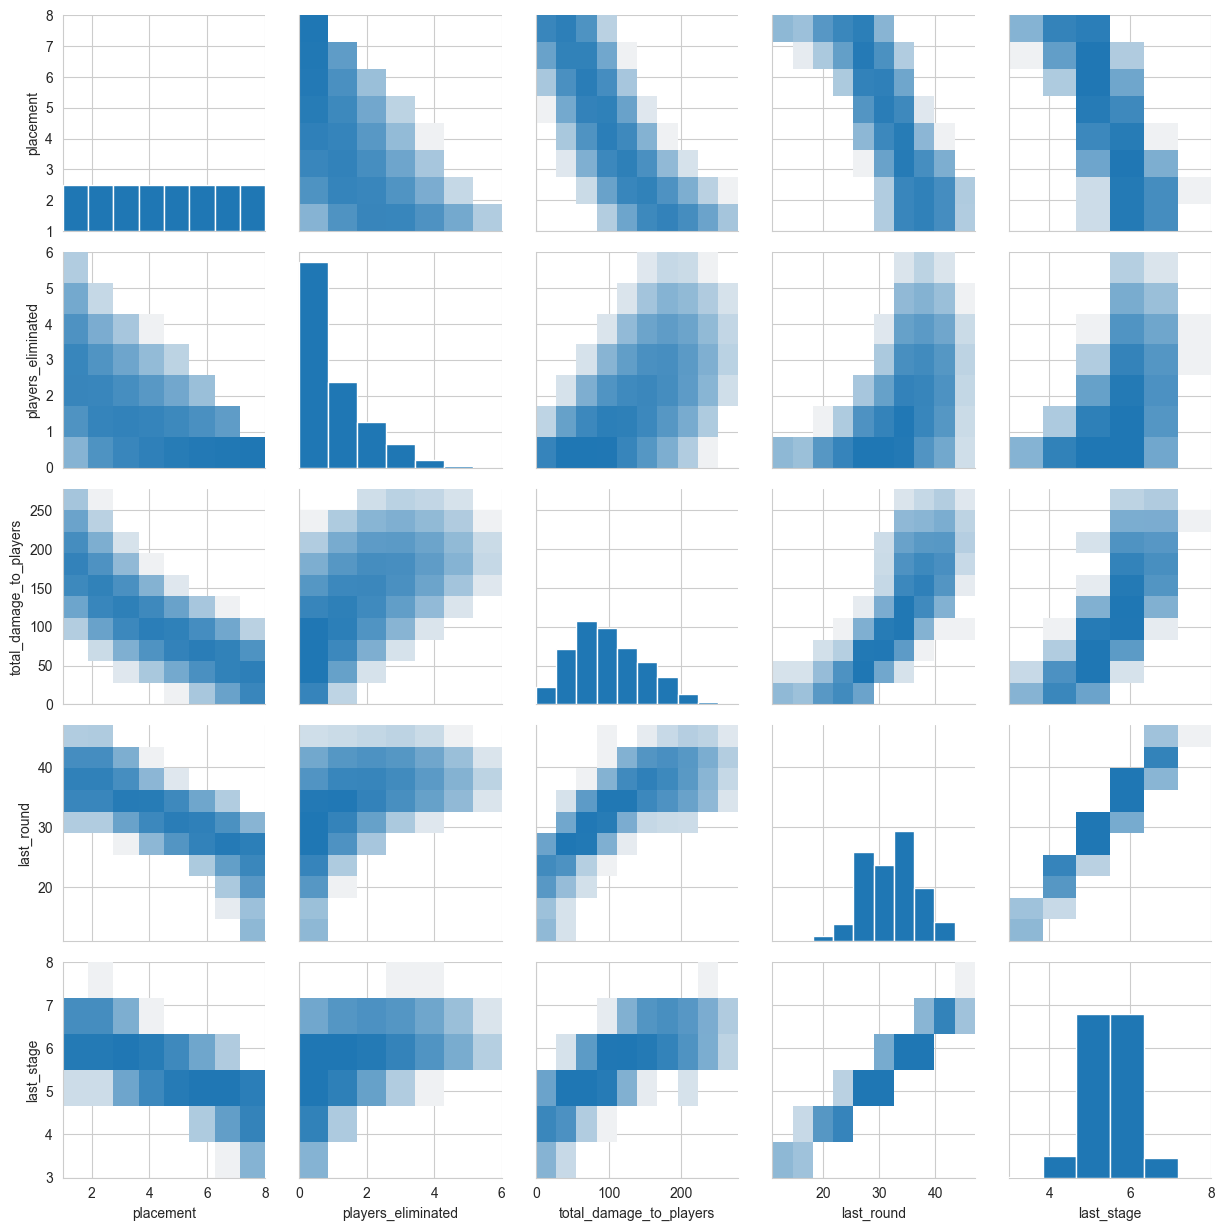

In [539]:
# Show outlier
min_val, max_val, mean, std = get_min_max_mean_std(numeric_features, "total_damage_to_players")
print(pd.cut(
    numeric_features["total_damage_to_players"], 
    bins=[min_val-1, mean+(5*std), max_val+1], 
    labels=[f"Under 5 Standard Deviations", f"Over 5 Standard Deviations"]
).value_counts())
numeric_features = numeric_features[numeric_features["total_damage_to_players"] < mean+(5*std)]
top_level_fields.remove("game_length")
top_level_grid = sns.PairGrid(numeric_features[top_level_fields])
top_level_grid.map_diag(wrap_hist)
top_level_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

Based on this plot, it seems large total_damage_to_players yields a lower (and therefore better) placement. Curiously players_eliminated doesn't seem to have as clear of a relationship with placement. Obviously eliminating other players has to yield a better placement (since that immediately puts someone else in a lower "placement slot"). But the dark area under the diagonal indicates that its still very common for a player to obtain a high placement without directly being the one to eliminate many of their opponents.

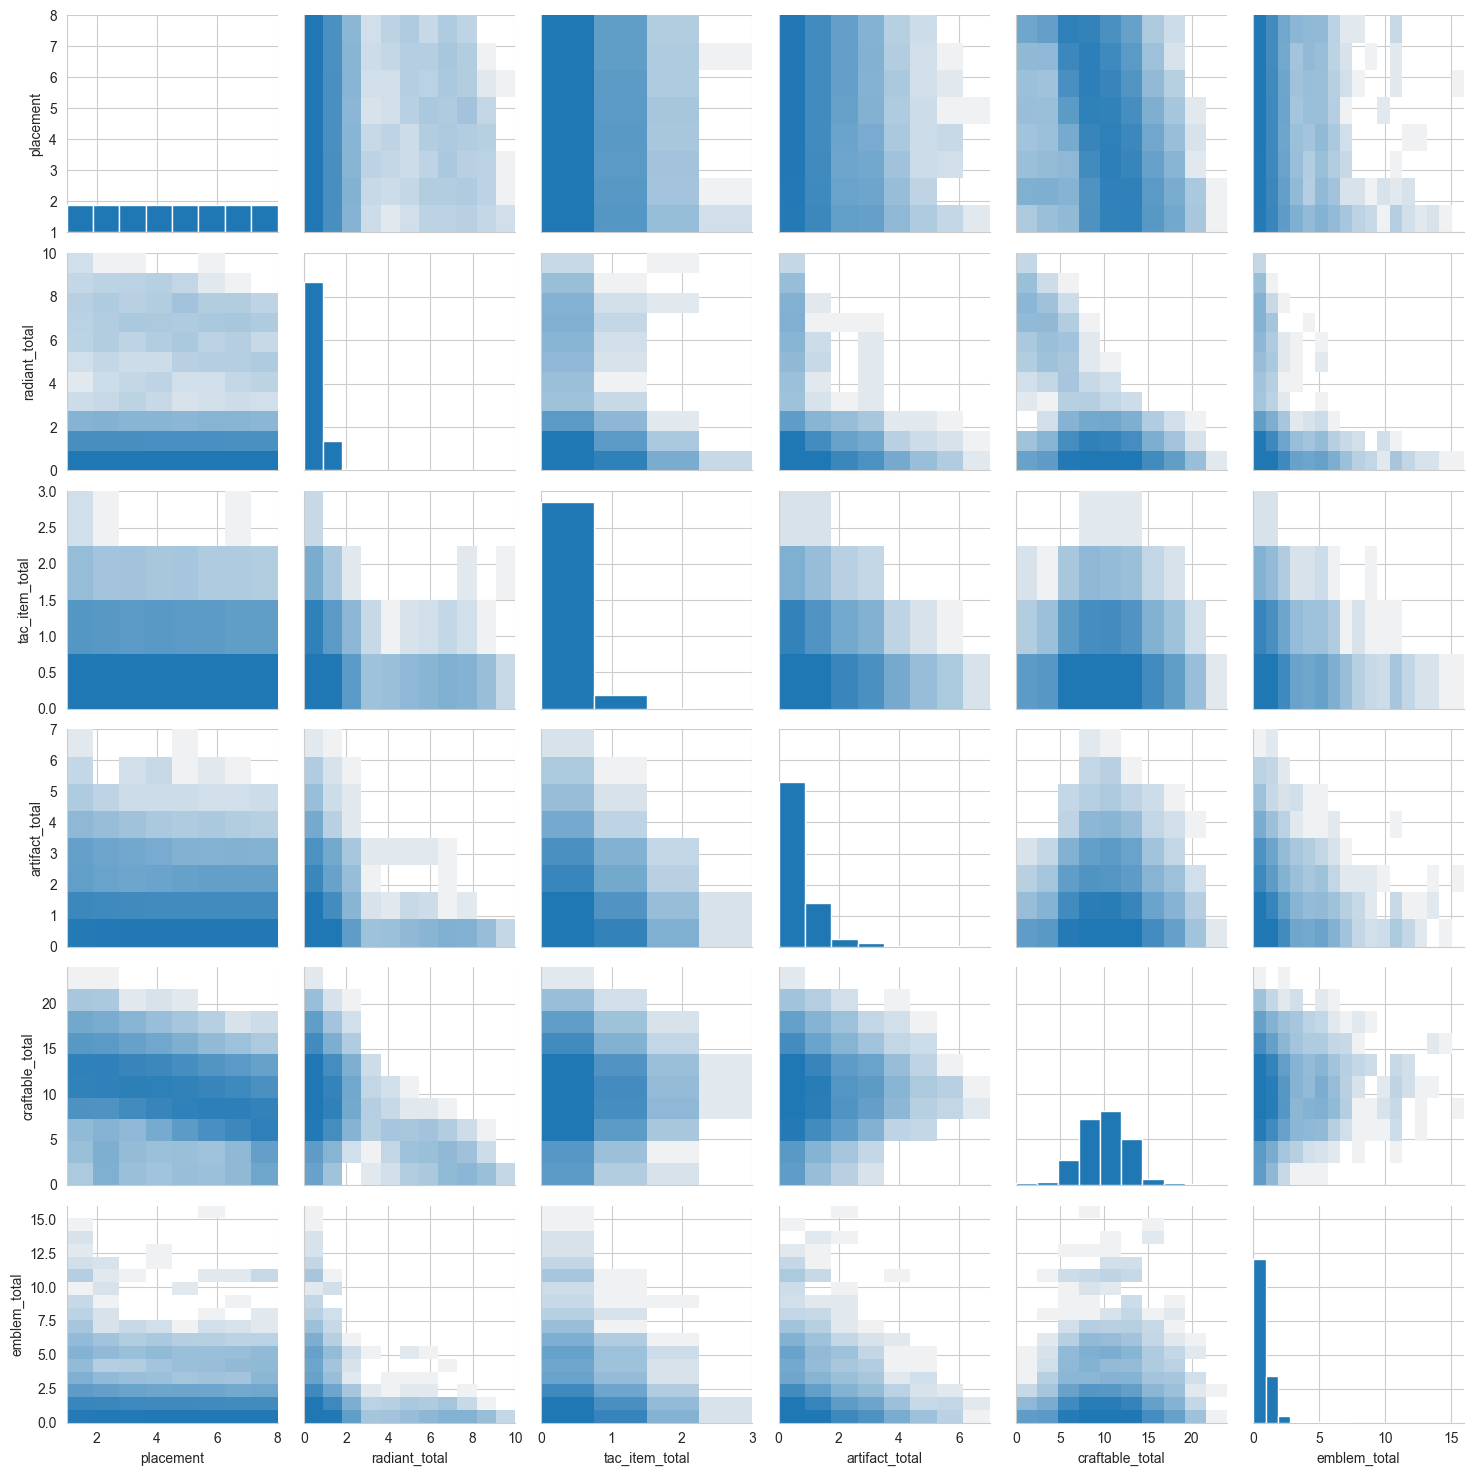

In [540]:
# Item fields - these were calculated based on what items the player's units were holding at the end of the game
item_fields = ["placement", "radiant_total", "tac_item_total", "artifact_total", "craftable_total", "emblem_total"]
items_grid = sns.PairGrid(numeric_features[item_fields])
items_grid.map_diag(wrap_hist)
items_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

As with the above plot, there is evidence of outliers, this time with emblem_total & radiant_total. As it turns out there are a few rarely-offered augments that, when selected by a player, can allow them to obtain a large number of emblem, artifact, or radiant items if the player fulfills some condition. Some of these are noted below:
| Item Type | Augment               |
|:----------|:----------------------|
| Artifact  | Living Forge          |
| Emblem    | Flexible              |
| Radiant   | Quality Over Quantity |

With that in mind, these outlier boards are likely a reflection on the value of those augments, but not necessarily on the holistic value of an emblem or radiant item. Since this model is focused on that holistic value, I am going to go ahead and remove these outliers.

Separate from these, the tac_item_total also has the hallmark of potential outliers. However, there aren't specific augments or other such options that a player can decide to take, that will specifically result in many "Tactician" items. As such I don't have strong reason to believe they will distort my modeling in any particular way, so I won't be removing them at this point.

emblem_total
Under 5 Standard Deviations    105144
Over 5 Standard Deviations        822
Name: count, dtype: int64
radiant_total
Under 5 Standard Deviations    105390
Over 5 Standard Deviations        576
Name: count, dtype: int64
artifact_total
Under 5 Standard Deviations    105632
Over 5 Standard Deviations        334
Name: count, dtype: int64


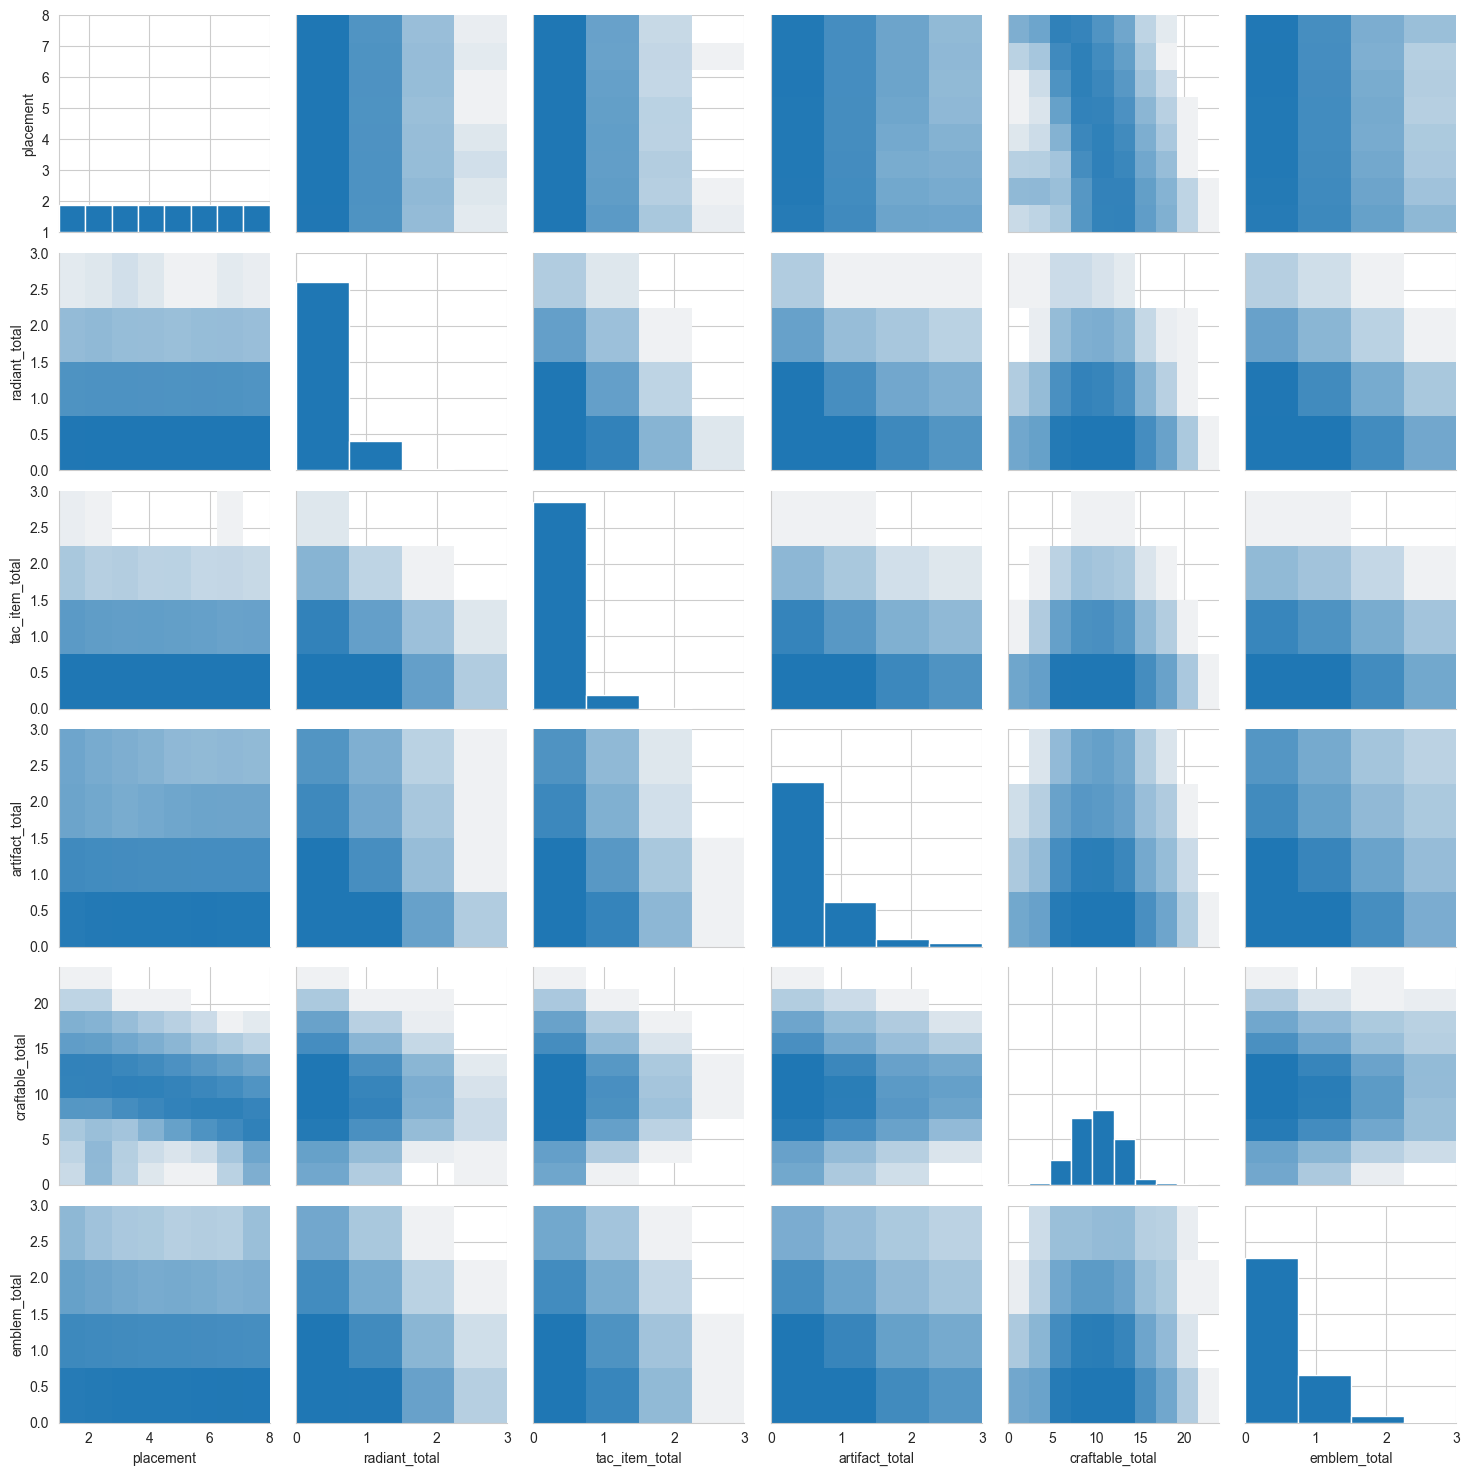

In [541]:
# Show outliers
min_val, max_val, mean, std = get_min_max_mean_std(numeric_features, "emblem_total")
print(pd.cut(
    numeric_features["emblem_total"], 
    bins=[min_val-1,mean+(5*std),max_val+1], 
    labels=[f"Under 5 Standard Deviations", 
            f"Over 5 Standard Deviations"]
).value_counts())

min_val, max_val, mean, std = get_min_max_mean_std(numeric_features, "radiant_total")
print(pd.cut(
    numeric_features["radiant_total"], 
    bins=[min_val-1,mean+(5*std),max_val+1], 
    labels=[f"Under 5 Standard Deviations", 
            f"Over 5 Standard Deviations"]
).value_counts())

min_val, max_val, mean, std = get_min_max_mean_std(numeric_features, "artifact_total")
print(pd.cut(
    numeric_features["artifact_total"], 
    bins=[min_val-1,mean+(5*std),max_val+1], 
    labels=[f"Under 5 Standard Deviations", 
            f"Over 5 Standard Deviations"]
).value_counts())

numeric_features = numeric_features[numeric_features["emblem_total"] < mean+(5*std)]
numeric_features = numeric_features[numeric_features["radiant_total"] < mean+(5*std)]
numeric_features = numeric_features[numeric_features["artifact_total"] < mean+(5*std)]

items_grid = sns.PairGrid(numeric_features[item_fields])
items_grid.map_diag(wrap_hist)
items_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

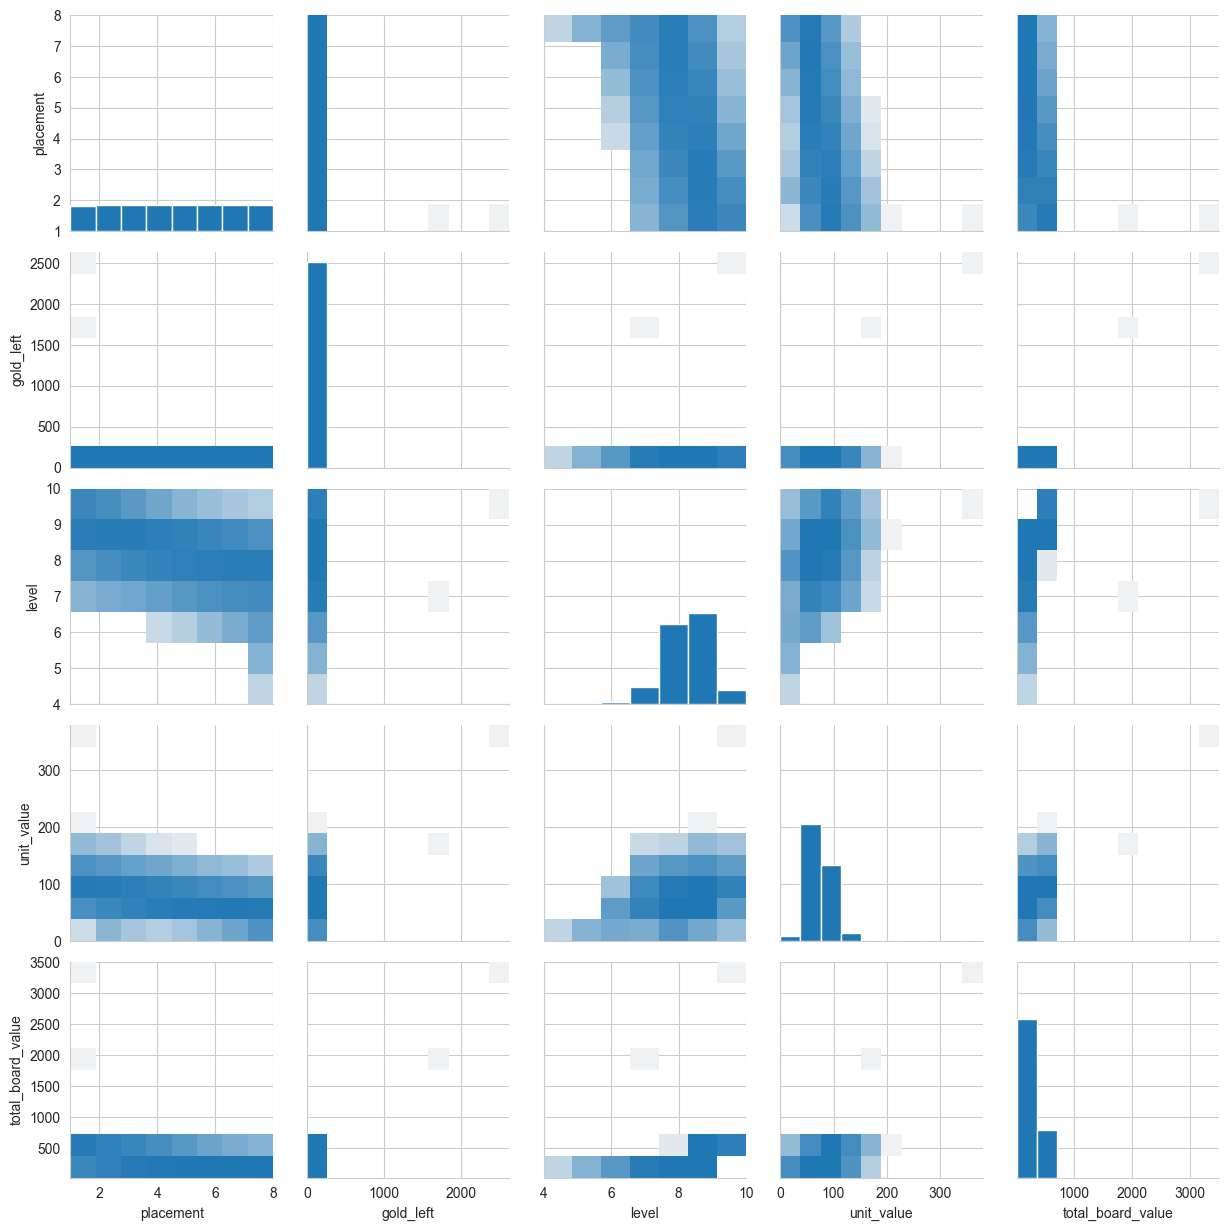

In [542]:
# total_board_value + fields that contributed to it
gold_value_fields = ["placement", "gold_left", "level", "unit_value", "total_board_value"]
gold_value_grid = sns.PairGrid(numeric_features[gold_value_fields])
gold_value_grid.map_diag(wrap_hist)
gold_value_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

Again there's clear outliers. In this case there are exactly two players in the data set that ended their game with an extraordinary amount of money in the bank. As with player damage, the extreme nature of these make me immediately comfortable with simply dropping them.

gold_left
Under 5 Standard Deviations    103766
Over 5 Standard Deviations        124
Name: count, dtype: int64


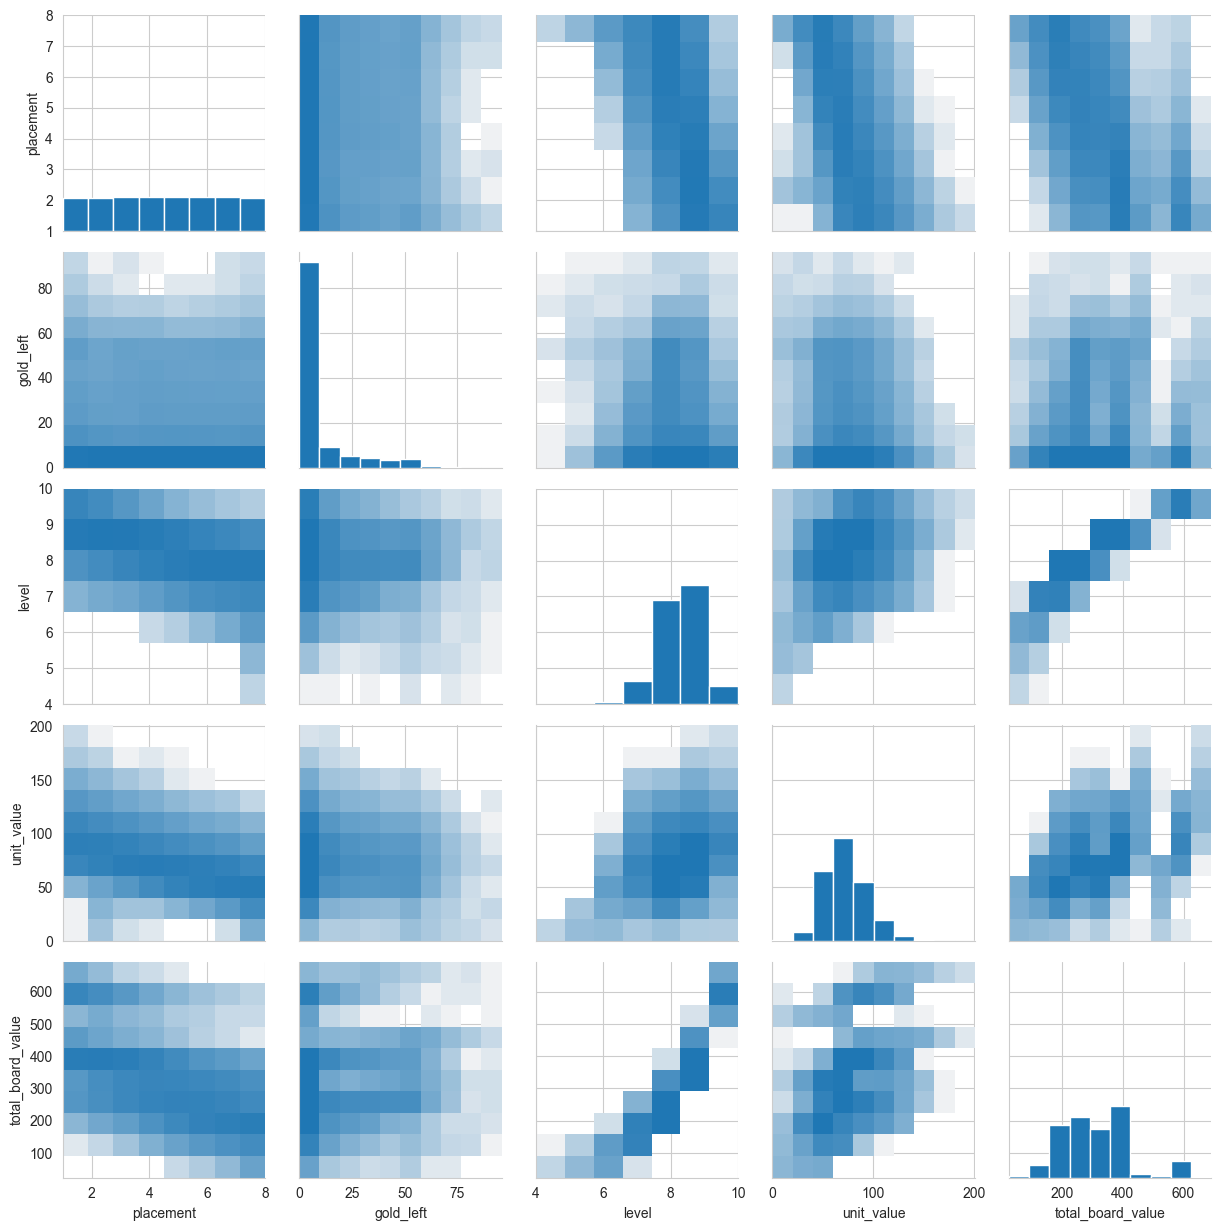

In [543]:
min_val, max_val, mean, std = get_min_max_mean_std(numeric_features, "gold_left")
print(pd.cut(
    numeric_features["gold_left"], 
    bins=[min_val-1,mean+(5*std),max_val+1], 
    labels=[f"Under 5 Standard Deviations", 
            f"Over 5 Standard Deviations"]
).value_counts())

numeric_features = numeric_features[numeric_features["gold_left"] < mean+(5*std)]

gold_value_grid = sns.PairGrid(numeric_features[gold_value_fields])
gold_value_grid.map_diag(wrap_hist)
gold_value_grid.map_offdiag(pairgrid_heatmap, norm=LogNorm())

From here, we can see that higher gold total will generally improve a player's standing, with one exception. Having high gold left in the bank at the end of the game, seems to not matter very much for final placement.

In [544]:
print(f"Number of records: {len(numeric_features)}")

Number of records: 103766


## Correlation Matrix Analysis
For this analysis, I am going to focus on the features connected with player resources. In a normal game of TFT, players are regularly given gold and craftable items without having to take any special actions. As such players tend to accumulate these as the game goes on, regardless of whether they are actively trying to optimize these resource quantities. Because of this, I strongly suspect craftable_items and total_board_value may be correlated (and even collinear) with last_round (indicates number of rounds a player lasted in the game). So even though last_round isn't describing a player resource per se, I am still going to include it in my correlation matrix to investigate this possibility.

In [545]:
def print_all_vifs(feature_df):
    for my_f in feature_df:
        if my_f == 'placement':
            continue
        print(f"{my_f} VIF: {vif(feature_df.values, feature_df.columns.get_loc(my_f))}")

radiant_total VIF: 1.177987178620635
tac_item_total VIF: 1.0936726615460948
artifact_total VIF: 1.2905945486456376
craftable_total VIF: 33.35262198147945
emblem_total VIF: 1.3157692904955838
gold_left VIF: inf
level VIF: 541.774410271115
total_board_value VIF: inf


D:\venvs\supervised_ml_final\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


player_level_value VIF: inf
unit_value VIF: inf
last_round VIF: 614.4831805012279
last_stage VIF: 447.56382388809385


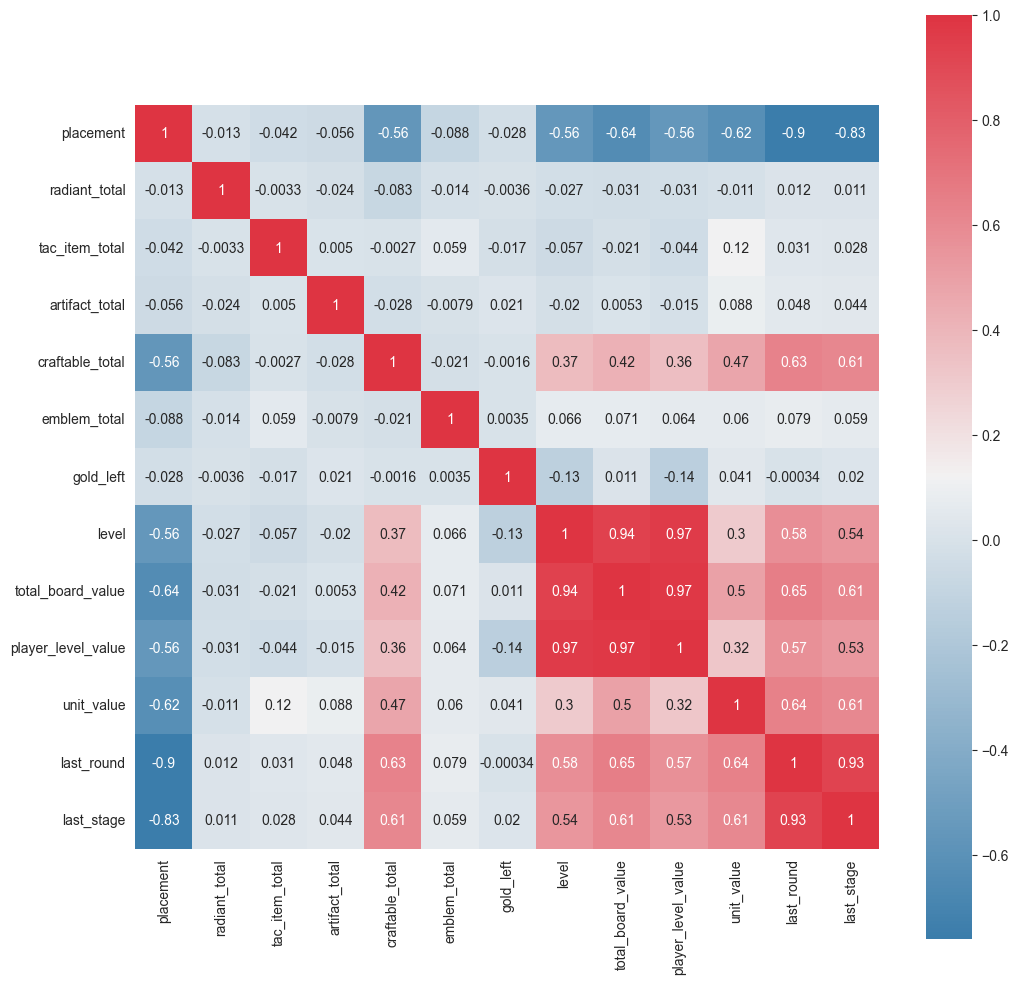

In [546]:
features_of_interest = [
    "placement", 
    "radiant_total", "tac_item_total", "artifact_total", "craftable_total", "emblem_total", 
    "gold_left", "level", "total_board_value", "player_level_value", "unit_value", "last_round", "last_stage"
]
selected_features = numeric_features[features_of_interest]

diverging_cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=80, l=50, center='light', as_cmap=True)
plt.figure(figsize=(12, 12))
corr_heat_map = sns.heatmap(selected_features.corr(), square=True, cmap=diverging_cmap, annot=True, robust=True)

# Calculate VIF for each feature
print_all_vifs(selected_features)


As I had anticipated, craftable_total & total_board value have a pretty strong correlation with last_round. And VIF metrics indicate there is in fact some collinearity with our features. This is not surprising, some of them were calculated/inferred from other ones). So as a first pass I'm going to whittle down the overlapping features.

radiant_total VIF: 1.1772229994308219
tac_item_total VIF: 1.0936191623160216
artifact_total VIF: 1.290006833130116
craftable_total VIF: 33.16037182000136
emblem_total VIF: 1.3127580765662148
gold_left VIF: 1.3655365711106742
player_level_value VIF: 9.86283927898312
unit_value VIF: 24.069193647568756
last_round VIF: 71.1657741565705


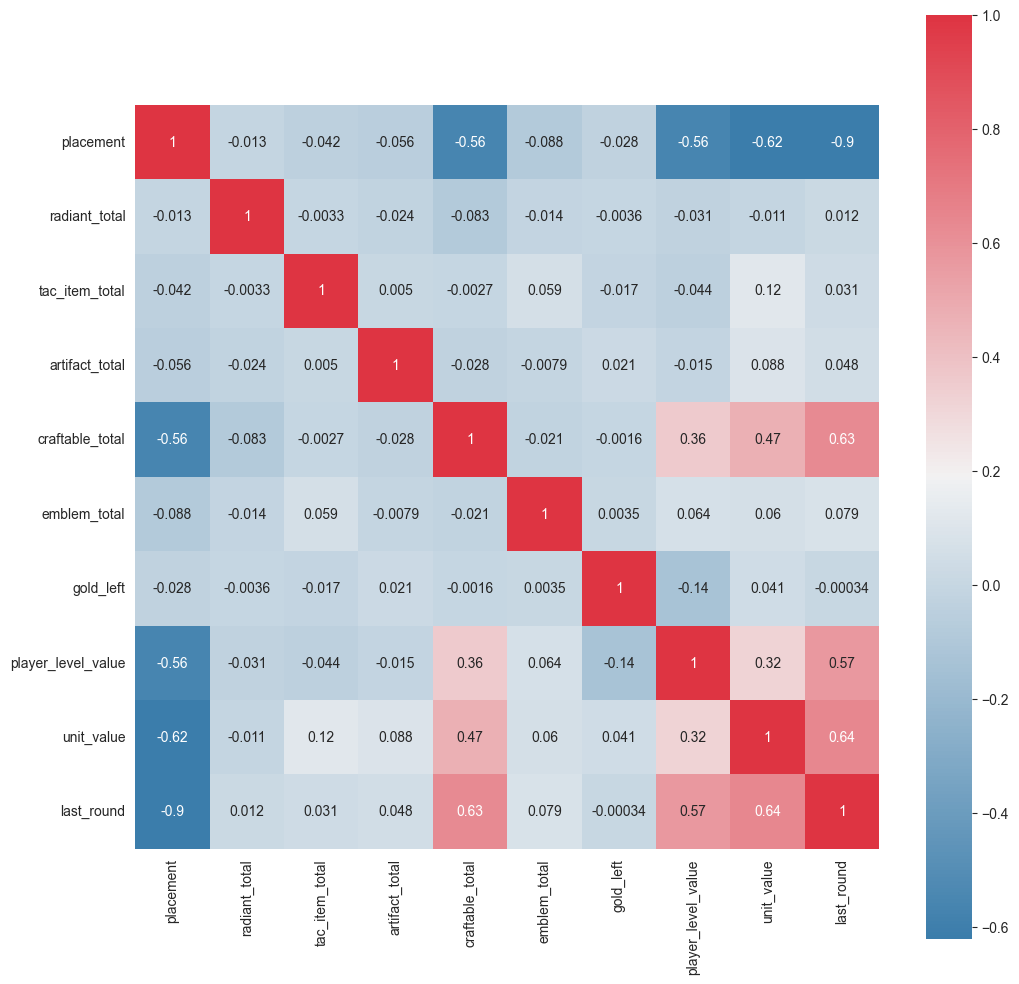

In [547]:
features_of_interest.remove("last_stage")
features_of_interest.remove("level")
features_of_interest.remove("total_board_value")

selected_features = numeric_features[features_of_interest]

diverging_cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=80, l=50, center='light', as_cmap=True)
plt.figure(figsize=(12, 12))
corr_heat_map = sns.heatmap(selected_features.corr(), square=True, cmap=diverging_cmap, annot=True, robust=True)

# Calculate VIF for each feature
print_all_vifs(selected_features)

Even with trimming calculated values, there is still signs of collinearity with craftable_total, player_level_value, unit_value, & last_round. This is particularly problematic in light of last_round itself having the strongest correlation with placement. This correlation is a direct consequence of TFT being a "Last Man Standing" game; a player that gets to play many round definitionally is doing better than a player that was eliminated earlier in the game. The features involved in this collinearity are also overwhelmingly dominant in their correlation with placement, which is probably connected to how they are implicitly tied to last_round.

I will need to do some kind of normalization transformation on my data to resolve this collinearity. But a key consideration here, is that I want to keep all the item totals in the same units & scale in order to keep them comparable (the data will not be very interpretable otherwise). I likewise need to keep the gold value total columns units consistent. A naive approach would be to divide all columns by last_round, thereby making everything expressed as a "per round" rate. However, this wouldn't be very meaningful for many item types; only craftables are typically gained in any "per round" basis, the others usually only get offered once or twice per game.

What I decided to do, is to re-center each column about a summary stat on a per round basis. Ergo instead of an absolute "craftable_total" I will be examining how many craftables a player has above the center value for the round they were eliminated. Thus, I will be able to answer questions such as "is it better to have an above-average number of artifacts, or an above-average number of radiants?". I will not be scaling the columns, because of my need to keep them all in the same scale. For my initial normalization attempt I will be using mean as my summary stat of choice for re-centering. I will also be clipping outliers from the last_round column, as some tail values do not have a high enough sample to produce a useful & trustworthy summary stat.

In [548]:
# Clip outliers from last_round
min_val, max_val, mean, std = get_min_max_mean_std(selected_features, "last_round")
print(pd.cut(
    selected_features["last_round"], 
    bins=[min_val-1,mean-(2.5*std),mean+(2.5*std),max_val+1],
    labels=["Under 2.5 Deviations", "Within 2.5 deviations", "Over 2.5 Deviations"]
).value_counts())
selected_features = selected_features[selected_features["last_round"] > mean-(2.5*std)]
selected_features = selected_features[selected_features["last_round"] < mean+(2.5*std)]

# Features sans placement & last_round
features_for_normalization = [
    "radiant_total", "tac_item_total", "artifact_total", "craftable_total", "emblem_total", 
    "gold_left", "player_level_value", "unit_value"
]

for f in features_for_normalization:
    averages = selected_features.groupby(['last_round'])[f].mean()
    averages.name = f"{f}_averages"
    selected_features = pd.merge(selected_features, averages, on='last_round')
    selected_features[f"{f}_normed"] = selected_features[f] - selected_features[f"{f}_averages"]
selected_features.describe()

last_round
Within 2.5 deviations    103147
Under 2.5 Deviations        560
Over 2.5 Deviations          59
Name: count, dtype: int64


,placement,radiant_total,tac_item_total,artifact_total,craftable_total,emblem_total,gold_left,player_level_value,unit_value,last_round,...,craftable_total_averages,craftable_total_normed,emblem_total_averages,emblem_total_normed,gold_left_averages,gold_left_normed,player_level_value_averages,player_level_value_normed,unit_value_averages,unit_value_normed
count,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,...,103147.000000,1.031470e+05,103147.000000,1.031470e+05,103147.000000,1.031470e+05,103147.000000,1.031470e+05,103147.000000,1.031470e+05
mean,4.488400,0.151725,0.063851,0.325642,10.025944,0.291380,8.070579,231.021028,73.046506,31.852376,...,10.025944,1.576121e-16,0.291380,2.479911e-18,8.070579,-1.873711e-16,231.021028,-5.219937e-15,73.046506,1.591552e-15
std,2.277168,0.383571,0.253061,0.630341,2.307903,0.542902,14.176310,100.387152,20.449226,4.456321,...,1.454044,1.792254e+00,0.054621,5.401477e-01,1.103934,1.413326e+01,57.901632,8.200598e+01,12.959510,1.581840e+01
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,21.000000,...,5.753623,-1.264715e+01,0.181818,-5.035971e-01,6.576970,-2.001911e+01,128.500000,-2.893200e+02,38.772727,-1.000800e+02
25%,3.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,160.000000,58.000000,28.000000,...,8.700186,-8.558098e-01,0.269389,-2.943396e-01,7.472569,-7.485183e+00,178.524699,-4.807837e+01,62.089895,-1.089883e+01
50%,4.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,286.000000,71.000000,31.000000,...,9.672956,-5.201824e-01,0.291282,-2.760490e-01,7.699457,-6.472569e+00,208.078374,-8.728775e+00,68.255636,-2.305485e+00
75%,6.000000,0.000000,0.000000,1.000000,11.000000,1.000000,8.000000,286.000000,86.000000,35.000000,...,10.855810,1.164440e+00,0.301557,6.084834e-01,8.365041,-3.553993e-01,282.022903,4.906364e+01,84.508187,8.648706e+00
max,8.000000,3.000000,3.000000,3.000000,24.000000,3.000000,96.000000,488.000000,201.000000,42.000000,...,12.647153,1.135285e+01,0.503597,2.786853e+00,20.019108,8.942303e+01,371.320000,3.402507e+02,100.080000,1.055621e+02


radiant_total_normed VIF: 1.0192048664604683
tac_item_total_normed VIF: 1.0273958009106037
artifact_total_normed VIF: 1.0168817033166746
craftable_total_normed VIF: 1.0464445341667754
emblem_total_normed VIF: 1.0130257200535455
gold_left_normed VIF: 1.0339634835923488
player_level_value_normed VIF: 1.0475258330751984
unit_value_normed VIF: 1.045496434574277


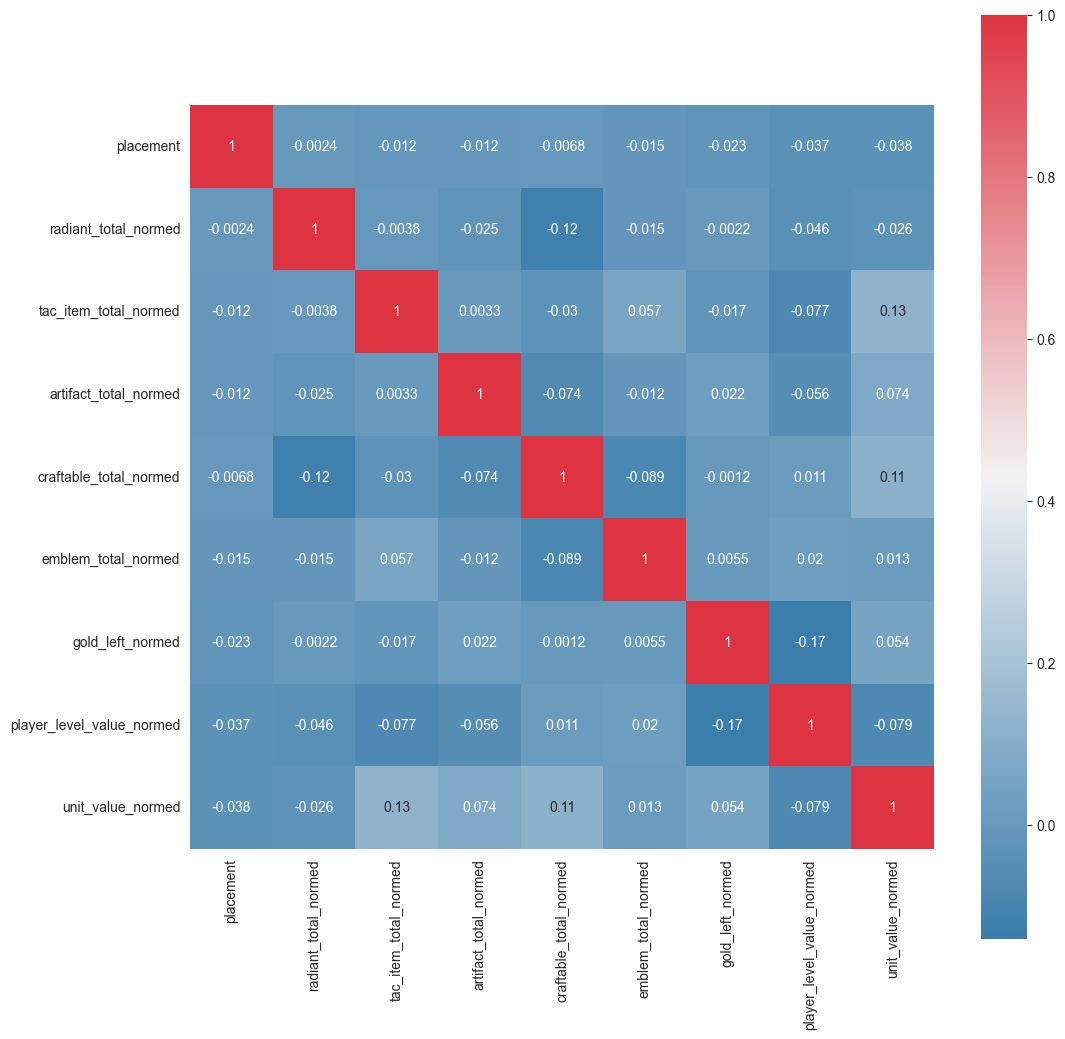

In [549]:
# Our new data set - leave out last_round, and un-normalized columns
normalized = selected_features[["placement"] + [f"{f}_normed" for f in features_for_normalization]]

diverging_cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=80, l=50, center='light', as_cmap=True)
plt.figure(figsize=(12, 12))
corr_heat_map = sns.heatmap(normalized.corr(), square=True, cmap=diverging_cmap, annot=True, robust=True)

# Calculate VIF for each feature
print_all_vifs(normalized)

That process removed our collinearity, but it also removed most of our correlations with placement as well. I am unlikely to obtain a good model with this data set. So I am going to re-try, using median as our summary stat instead.

In [550]:
# Clip outliers from last_round
min_val, max_val, mean, std = get_min_max_mean_std(selected_features, "last_round")
print(pd.cut(
    selected_features["last_round"], 
    bins=[min_val-1,mean-(2.5*std),mean+(2.5*std),max_val+1],
    labels=["Under 2.5 Deviations", "Within 2.5 deviations", "Over 2.5 Deviations"]
).value_counts())
selected_features = selected_features[selected_features["last_round"] > mean-(2.5*std)]
selected_features = selected_features[selected_features["last_round"] < mean+(2.5*std)]

# Features sans placement & last_round
features_for_normalization = [
    "radiant_total", "tac_item_total", "artifact_total", "craftable_total", "emblem_total", 
    "gold_left", "player_level_value", "unit_value"
]

for f in features_for_normalization:
    medians = selected_features.groupby(['last_round'])[f].median()
    medians.name = f"{f}_median"
    selected_features = pd.merge(selected_features, medians, on='last_round')
    selected_features[f"{f}_normed"] = selected_features[f] - selected_features[f"{f}_median"]
selected_features.describe()

last_round
Within 2.5 deviations    103147
Under 2.5 Deviations          0
Over 2.5 Deviations           0
Name: count, dtype: int64


,placement,radiant_total,tac_item_total,artifact_total,craftable_total,emblem_total,gold_left,player_level_value,unit_value,last_round,...,unit_value_averages,unit_value_normed,radiant_total_median,tac_item_total_median,artifact_total_median,craftable_total_median,emblem_total_median,gold_left_median,player_level_value_median,unit_value_median
count,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,103147.000000,...,103147.000000,103147.000000,103147.0,103147.0,103147.0,103147.000000,103147.0,103147.000000,103147.000000,103147.000000
mean,4.488400,0.151725,0.063851,0.325642,10.025944,0.291380,8.070579,231.021028,73.046506,31.852376,...,73.046506,2.229798,0.0,0.0,0.0,9.671314,0.0,1.258369,222.797832,70.816708
std,2.277168,0.383571,0.253061,0.630341,2.307903,0.542902,14.176310,100.387152,20.449226,4.456321,...,12.959510,15.827083,0.0,0.0,0.0,1.665814,0.0,0.945733,62.999981,12.737412
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,21.000000,...,38.772727,-98.000000,0.0,0.0,0.0,6.000000,0.0,1.000000,160.000000,38.000000
25%,3.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,160.000000,58.000000,28.000000,...,62.089895,-9.000000,0.0,0.0,0.0,8.000000,0.0,1.000000,160.000000,60.000000
50%,4.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,286.000000,71.000000,31.000000,...,68.255636,0.000000,0.0,0.0,0.0,9.000000,0.0,1.000000,160.000000,65.000000
75%,6.000000,0.000000,0.000000,1.000000,11.000000,1.000000,8.000000,286.000000,86.000000,35.000000,...,84.508187,11.000000,0.0,0.0,0.0,11.000000,0.0,1.000000,286.000000,82.000000
max,8.000000,3.000000,3.000000,3.000000,24.000000,3.000000,96.000000,488.000000,201.000000,42.000000,...,100.080000,108.000000,0.0,0.0,0.0,13.000000,0.0,16.000000,286.000000,98.000000


radiant_total_normed VIF: 1.1350803321130756
tac_item_total_normed VIF: 1.0774665549121718
artifact_total_normed VIF: 1.206528039969972
craftable_total_normed VIF: 1.0905154640158923
emblem_total_normed VIF: 1.2114672300051237
gold_left_normed VIF: 1.2153435509236328
player_level_value_normed VIF: 1.0434298285588919
unit_value_normed VIF: 1.0653196497981272


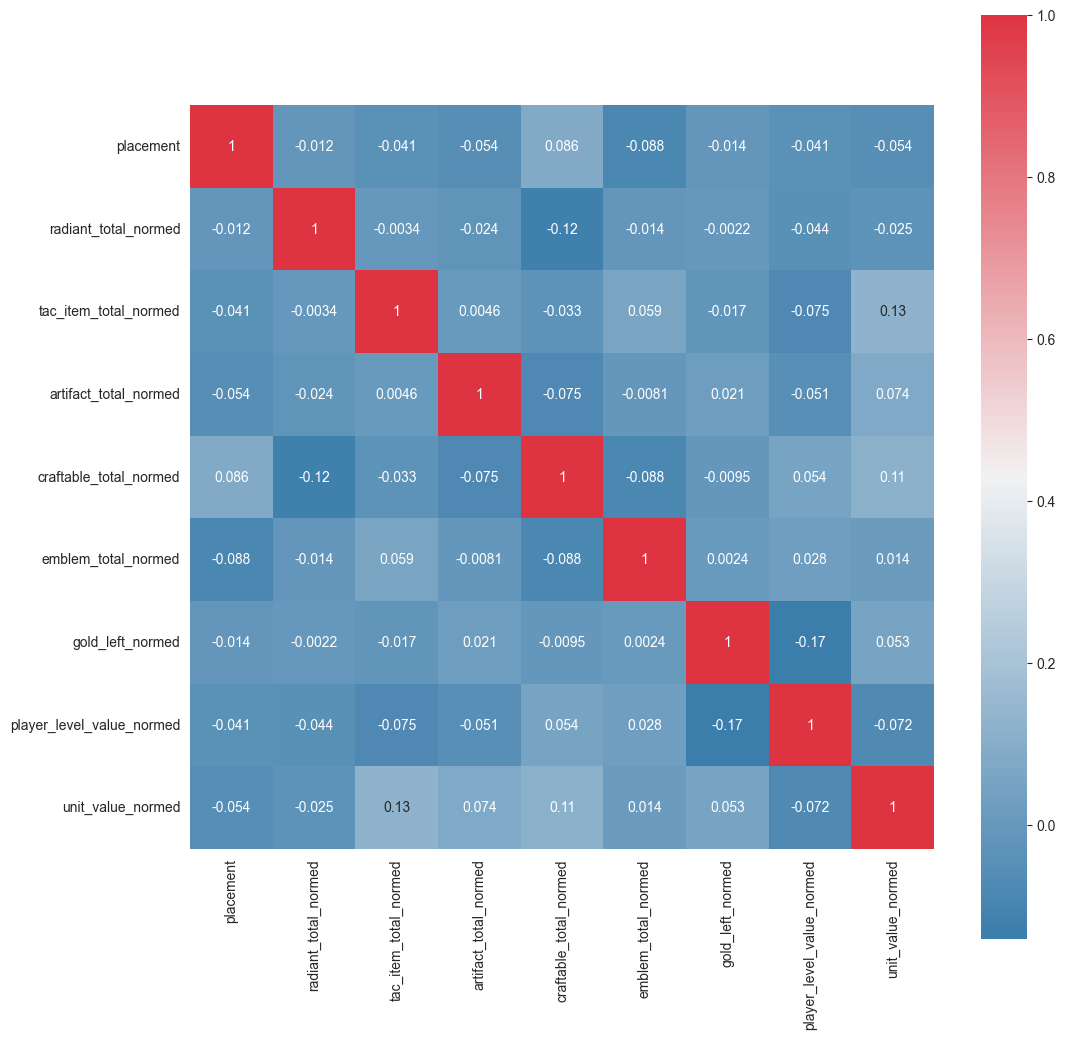

In [551]:
# Our new data set - leave out last_round, and un-normalized columns
normalized = selected_features[["placement"] + [f"{f}_normed" for f in features_for_normalization]]

diverging_cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=80, l=50, center='light', as_cmap=True)
plt.figure(figsize=(12, 12))
corr_heat_map = sns.heatmap(normalized.corr(), square=True, cmap=diverging_cmap, annot=True, robust=True)

# Calculate VIF for each feature
print_all_vifs(normalized)

The correlations are still weak, but not completely non-existent as it was when centering about the mean. I suspect median performing better is because many of my features do not follow normal distributions (see pair plots).

## EDA Summary

After sifting through many data pair plots, I identified outlier cases that I determined should be trimmed from my dataset prior to attempting any modeling. Outliers were defined as being either outside 5 standard deviations centered at the mean (for features w/ an approximately normal distribution), or outside 5 standard deviations above the mean (for features w/ leftward-skewed distributions). There were ultimately 2,821 outlier records that were removed, which is approximately 2.7% of the data set that had made it through initial filtering. 

Analysis of the correlation matrix and variance inflation factors demonstrated clear collinearity between some of my features. Some of this collinearity I was able to resolve by removing features that I knew to be fully redundant (ie one feature calculated from another). The rest I knew to be a consequence of the data itself, and had to address via a normalization procedure. The resulting features have weak correlations with placement, so I probably won't get a very strong model. However, I don't think that there are much better ways to correct for it within the scope of this project, so I am going to go forward and try to construct a model with this current data set.

# Initial Modeling

## Feature Selection
Because I don't have a particularly large number of features, its feasible for me to run a full best subset selection search.

In [552]:
# This should correspond to step #1 from algo 6.2 - setting up the null model
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(normalized, train_size=.8, random_state=0)

test_true_placements = test_set['placement']
test_ind_vars = test_set.drop('placement', axis='columns')

train_true_placements = train_set['placement']
train_ind_vars = train_set.drop('placement', axis='columns')

model_list = []


for k in range(1, len(train_ind_vars.columns)+1):
    r2_values = []
    for feature_combo in itertools.combinations(train_ind_vars.columns, k):
        formula = f'placement ~ {" + ".join(feature_combo)}'
        tmp_model = smf.ols(formula=formula, data=train_set).fit()
        r2_values.append(
            {
                "features": feature_combo,
                "train_adj_r2": tmp_model.rsquared_adj,
                "model": tmp_model
            })
    r2_values = sorted(r2_values, key = lambda x: x["train_adj_r2"], reverse=True)
    best_model_dict = r2_values[0]
    placement_pred = best_model_dict["model"].predict(test_set)
    
    best_model_dict["test_r2"] = r2_score(test_true_placements, placement_pred)
    N = len(test_true_placements)
    p = len(test_ind_vars.columns)
    best_model_dict["test_adj_r2"] = 1-((1-best_model_dict["test_r2"])*(N-1)/(N-p-1))
    model_list.append(best_model_dict)

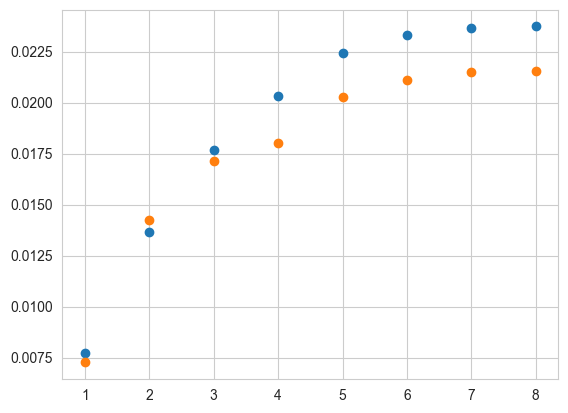

In [553]:
plt.scatter(range(1, len(model_list)+1), [x["train_adj_r2"] for x in model_list], label='train')
plt.scatter(range(1, len(model_list)+1), [x["test_adj_r2"] for x in model_list], label='test')  

Based on the above plot, improvements to adjusted R-squared level off after the 6 predictor mark. Therefore I'll be examining my best 6-predictor model in more detail.

## Modeling & Analysis

In [554]:
six_pred_model = model_list[5]["model"]
six_pred_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     329.5
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:24:13   Log-Likelihood:            -1.8404e+05
No. Observations:               82517   AIC:                         3.681e+05
Df Residuals:                   82510   BIC:                         3.682e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.6509      0.010    454.685      0.000       4.631       4.671
tac_item_total_normed        -0.2763      0.031     -8.811      0.000      -0.338      -0.215
artifact_total_normed        -0.1680      0.013    -13.420      0.000      -0.193      -0.143
craftable_total_normed        0.1032      0.004     23.780      0.000       0.095       0.112
emblem_total_normed          -0.3223      0.015    -22.172      0.000      -0.351      -0.294
player_level_value_normed    -0.0014   9.01e-05    -16.006      0.000      -0.002      -0.001
unit_value_normed            -0.0087      0.001    -17.156      0.000      -0.010      -0.008
==============================================================================
Omnibus:                    68368.270   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4895.020
Skew:                           0.018   Prob(JB):                         0.00
Kurtosis:                       1.807   Cond. No.                         353.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although this model clearly isn't very good (R = 0.023), the coefficients all have P values indicating significance, and it lines up with some of my domain-knowledge intuitions:

* *Intercept = 4.6509*: this is reasonably close to 4.5, the midpoint of the placement range. Most of the other coefficients are negative, indicating that higher levels of those resources lowers placement, which means a better game outcome for the player.
* *player_level_value_normed = -0.0014, unit_value_normed = -0.0087*: High-level players have long suggested that additional units are not very impactful if you don't have items to give them. This seems pretty in-line with that notion.

Next I am going to see if there are any interactions that could improve the model.

In [555]:
formula = "placement ~ unit_value_normed*player_level_value_normed*tac_item_total_normed*artifact_total_normed*craftable_total_normed*emblem_total_normed"
interactions_model = smf.ols(formula=formula, data=train_set).fit()
interactions_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     40.76
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:24:14   Log-Likelihood:            -1.8375e+05
No. Observations:               82517   AIC:                         3.676e+05
Df Residuals:                   82453   BIC:                         3.682e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================================================
                                                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                              4.6497      0.011    426.613      0.000       4.628       4.671
unit_value_normed                                                                                                                     -0.0037      0.001     -5.339      0.000      -0.005      -0.002
player_level_value_normed                                                                                                             -0.0012      0.000     -9.122      0.000      -0.001      -0.001
unit_value_normed:player_level_value_normed                                                                                         -3.95e-05   7.52e-06     -5.251      0.000   -5.42e-05   -2.48e-05
tac_item_total_normed                                                                                                                 -0.1874      0.049     -3.814      0.000      -0.284      -0.091
unit_value_normed:tac_item_total_normed                                                                                               -0.0088      0.003     -3.133      0.002      -0.014      -0.003
player_level_value_normed:tac_item_total_normed                                                                                        0.0014      0.001      2.371      0.018       0.000       0.002
unit_value_normed:player_level_value_normed:tac_item_total_normed                                                                   3.247e-05    2.5e-05      1.301      0.193   -1.65e-05    8.14e-05
artifact_total_normed                                                                                                                 -0.1303      0.015     -8.662      0.000      -0.160      -0.101
unit_value_normed:artifact_total_normed                                                                                               -0.0070      0.001     -7.933      0.000      -0.009      -0.005
player_level_value_normed:artifact_total_normed                                                                                        0.0006      0.000      3.146      0.002       0.000       0.001
unit_value_normed:player_level_value_normed:artifact_total_normed                                                                  -2.583e-05   9.25e-06     -2.792      0.005    -4.4e-05    -7.7e-06
tac_item_total_normed:artifact_total_normed                                                       

As one can see, most of the interactions are not statistically significant. Most fascinating is that player_level_value_normed & unit_value_normed, while having the smallest overall coefficients, still have interactions with everything else. This is most likely a symptom of additional units being most impactful when they have items equipped - so they don't matter much in a vacuum, but in concert with the presence of above-average item counts, they make a much bigger difference. Re-running the regression with all interactions with p-value < .05 yields:



In [556]:
formula = ("placement ~ "
           "unit_value_normed*player_level_value_normed*tac_item_total_normed + "
           "unit_value_normed*player_level_value_normed*artifact_total_normed + "
           "unit_value_normed*player_level_value_normed*craftable_total_normed + "
           "unit_value_normed*player_level_value_normed*emblem_total_normed + "
           "craftable_total_normed:emblem_total_normed + artifact_total_normed:craftable_total_normed")
interactions_model = smf.ols(formula=formula, data=train_set).fit()
interactions_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     120.3
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:24:14   Log-Likelihood:            -1.8377e+05
No. Observations:               82517   AIC:                         3.676e+05
Df Residuals:                   82495   BIC:                         3.678e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              4.6496      0.010    445.029      0.000       4.629       4.670
unit_value_normed                                                     -0.0037      0.001     -5.692      0.000      -0.005      -0.002
player_level_value_normed                                             -0.0011      0.000     -9.186      0.000      -0.001      -0.001
unit_value_normed:player_level_value_normed                        -3.659e-05   6.97e-06     -5.253      0.000   -5.02e-05   -2.29e-05
tac_item_total_normed                                                 -0.1796      0.036     -4.976      0.000      -0.250      -0.109
unit_value_normed:tac_item_total_normed                               -0.0068      0.002     -3.529      0.000      -0.011      -0.003
player_level_value_normed:tac_item_total_normed                        0.0017      0.000      4.063      0.000       0.001       0.003
unit_value_normed:player_level_value_normed:tac_item_total_normed   1.691e-05   1.75e-05      0.969      0.333   -1.73e-05    5.11e-05
artifact_total_normed                                                 -0.1333      0.013    -10.268      0.000      -0.159      -0.108
unit_value_normed:artifact_total_normed                               -0.0072      0.001     -9.768      0.000      -0.009      -0.006
player_level_value_normed:artifact_total_normed                        0.0004      0.000      2.800      0.005       0.000       0.001
unit_value_normed:player_level_value_normed:artifact_total_normed  -2.463e-05   7.29e-06     -3.376      0.001   -3.89e-05   -1.03e-05
craftable_total_normed                                                 0.0911      0.005     16.817      0.000       0.080       0.102
unit_value_normed:craftable_total_normed                              -0.0023      0.000    -11.305      0.000      -0.003      -0.002
player_level_value_normed:craftable_total_normed                      -0.0002   4.56e-05     -4.577      0.000      -0.000      -0.000
unit_value_normed:player_level_value_normed:craftable_total_normed -1.126e-05   1.62e-06     -6.940      0.000   -1.44e-05   -8.08e-06
emblem_total_normed                                                   -0.2999      0.015    -19.942      0.000      -0.329      -0.270
unit_value_normed:emblem_total_normed                                 -0.0031      0.001     -3.390      0.001      -0.005      -0.001
player_level_value_normed:emblem_total_normed                         -0.0007      0.000     -3.921      0.000      -0.001      -0.000
unit_value_normed:player_level_value_normed:emblem_total_normed     1.621e-05   8.94e-06      1.814      0.070   

Amazingly, most of these interactions are still statistically significant. A few are not, so I'm going to do one last pass to obtain my final model:

In [569]:
formula = ("placement ~ "
           "unit_value_normed*tac_item_total_normed + player_level_value_normed*tac_item_total_normed + "
           "unit_value_normed*player_level_value_normed*artifact_total_normed + "
           "unit_value_normed*player_level_value_normed*craftable_total_normed + "
           "unit_value_normed*emblem_total_normed + player_level_value_normed*emblem_total_normed + "
           "artifact_total_normed:craftable_total_normed")
interactions_model = smf.ols(formula=formula, data=train_set).fit()
interactions_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     139.9
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:35:25   Log-Likelihood:            -1.8378e+05
No. Observations:               82517   AIC:                         3.676e+05
Df Residuals:                   82498   BIC:                         3.678e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              4.6485      0.010    447.046      0.000       4.628       4.669
unit_value_normed                                                     -0.0039      0.001     -5.944      0.000      -0.005      -0.003
tac_item_total_normed                                                 -0.1756      0.036     -4.880      0.000      -0.246      -0.105
unit_value_normed:tac_item_total_normed                               -0.0075      0.002     -4.114      0.000      -0.011      -0.004
player_level_value_normed                                             -0.0012      0.000     -9.832      0.000      -0.001      -0.001
player_level_value_normed:tac_item_total_normed                        0.0020      0.000      6.253      0.000       0.001       0.003
unit_value_normed:player_level_value_normed                        -2.992e-05   6.24e-06     -4.796      0.000   -4.22e-05   -1.77e-05
artifact_total_normed                                                 -0.1331      0.013    -10.246      0.000      -0.159      -0.108
unit_value_normed:artifact_total_normed                               -0.0071      0.001     -9.685      0.000      -0.009      -0.006
player_level_value_normed:artifact_total_normed                        0.0004      0.000      2.810      0.005       0.000       0.001
unit_value_normed:player_level_value_normed:artifact_total_normed    -2.4e-05   7.28e-06     -3.296      0.001   -3.83e-05   -9.73e-06
craftable_total_normed                                                 0.0947      0.005     19.142      0.000       0.085       0.104
unit_value_normed:craftable_total_normed                              -0.0023      0.000    -11.064      0.000      -0.003      -0.002
player_level_value_normed:craftable_total_normed                      -0.0002   4.55e-05     -4.511      0.000      -0.000      -0.000
unit_value_normed:player_level_value_normed:craftable_total_normed -1.097e-05   1.62e-06     -6.779      0.000   -1.41e-05    -7.8e-06
emblem_total_normed                                                   -0.3009      0.015    -20.053      0.000      -0.330      -0.271
unit_value_normed:emblem_total_normed                                 -0.0027      0.001     -2.977      0.003      -0.004      -0.001
player_level_value_normed:emblem_total_normed                         -0.0005      0.000     -3.306      0.001      -0.001      -0.000
artifact_total_normed:craftable_total_normed                           0.0423      0.007      5.838      0.000       0.028       0.056
==============================================================================
Omnibus:                    59095.

In [558]:
# Run our model vs the test set...
placement_pred = interactions_model.predict(test_set)
test_r2 = r2_score(test_true_placements, placement_pred)
N = len(test_true_placements)
p = len(test_ind_vars.columns)
test_adj_r2 = 1-((1-test_r2)*(N-1)/(N-p-1))

print(f"Adjusted R2 for Test Set: {test_adj_r2}")

Adjusted R2 for Test Set: 0.026311352496191653


## Conclusions

Sadly the final model still did not have a great overall performance. That this would be the case, was clear after I resolved the collinearities in my predictors. But I still feel it was a worthwhile exercise, as it yielded loads of interesting information such as potential nuances in relative item type value. I suspect that the low correlations in the normalized features are because in TFT, your overall board strength is always judged in relation to the other players in your specific game. As such, while a player with more resources than the "overall" average will be expected to perform a little better, what really matters is if they have more resources than the players they are currently competing with. Were I to re-attempt this analysis, I would want to find some way to normalize player resources on a per-game basis, and examine whether that information could serve as a better predictor instead.